In [1]:
import pyzed.sl as sl
import numpy as np
import matplotlib.pyplot as plt

In [46]:
def main(x):
    # Create a Camera object
    zed = sl.Camera()

    # Create a InitParameters object and set configuration parameters
    init_params = sl.InitParameters()
    #init_params.depth_mode = sl.DEPTH_MODE.ULTRA  # Use ULTRA depth mode
    init_params.depth_mode = sl.DEPTH_MODE.NEURAL  # Use AI depth mode
    init_params.coordinate_units = sl.UNIT.METER  # Use meter units (for depth measurements)
    init_params.camera_resolution = sl.RESOLUTION.HD2K # Resolution 2k frame rate 15fps only
    #init_parameters.depth_stabilization = false #disable depth stabilization(averaging few frames)

    tracking_parameters = sl.PositionalTrackingParameters()
    tracking_parameters.set_as_static = True

    # Open the camera
    err = zed.open(init_params)
    if err != sl.ERROR_CODE.SUCCESS:
        exit(1)

    # Create and set RuntimeParameters after opening the camera
    runtime_parameters = sl.RuntimeParameters()
    runtime_parameters.confidence_threshold = 100 #at 100 no pixel will be rejected
    runtime_parameters.texture_confidence_threshold = 100

    
    i = 0
    image = sl.Mat()
    image2 = sl.Mat()
    depth = sl.Mat()
    depth2 = sl.Mat()
    point_cloud = sl.Mat()
    normal = sl.Mat()
    depthlist=[]
    normallist=[]

    mirror_ref = sl.Transform()
    mirror_ref.set_translation(sl.Translation(2.75,4.0,0))

    # Capture x images, pcd, and depth, then stop
    while i < x:
        # A new image is available if grab() returns SUCCESS
        if (zed.grab() == sl.ERROR_CODE.SUCCESS):
            
            # Retrieve left and right image
            zed.retrieve_image(image, sl.VIEW.LEFT)
            image.write(f'output/img/image_{i:03}imgL.jpg')
            zed.retrieve_image(image2, sl.VIEW.RIGHT)
            image2.write(f'output/img/image_{i:03}imgR.jpg')

            # Retrieve depth map. Depth is aligned on the left image
            zed.retrieve_measure(depth2, sl.MEASURE.DEPTH)# raw measurement of depth
            zed.retrieve_image(depth, sl.VIEW.DEPTH)# this give an image for displaying, value scaled
            depth.write(f'output/depth/depth_{i:03}img.jpg')
            depth2.write(f'output/depth/depth2_{i:03}img.png')
            depthlist.append((depth2.numpy()).copy())
            
            # Retrieve colored point cloud. Point cloud is aligned on the left image.
            zed.retrieve_measure(point_cloud, sl.MEASURE.XYZRGBA)
            point_cloud.write(f'output/pcd/pc_{i:03}img.pcd')
            
            # Retrieve normal. normal is aligned on the left image.
            zed.retrieve_measure(normal, sl.MEASURE.NORMALS)
            normal.write(f'output/normal/normal_{i:03}img.pcd')
            normallist.append((normal.numpy()).copy())
            i = i + 1

    # Close the camera
    zed.close()
    return depthlist, normallist


In [47]:

if __name__ == "__main__":
    depthlist, normallist=main(10)

In [53]:
np.save('output/depthlist.npy',depthlist)
np.save('output/normallist.npy',normallist)

In [54]:
avg1=np.load('output/depthlist.npy')
avg=np.ma.masked_invalid(np.dstack(avg1))

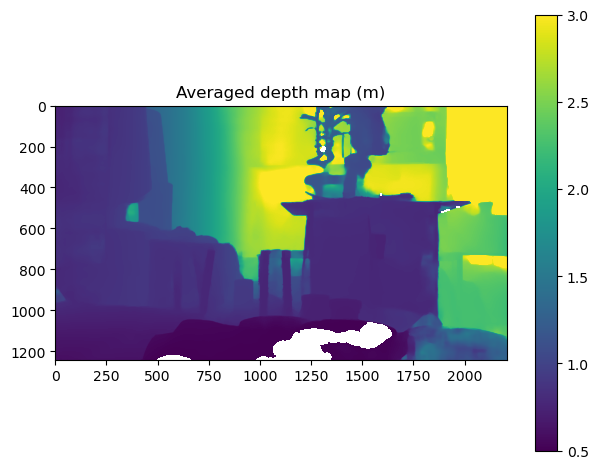

In [55]:
plt.imshow(np.mean(avg,axis=2), vmax=3)
plt.colorbar()
plt.title('Averaged depth map (m)')
plt.tight_layout()

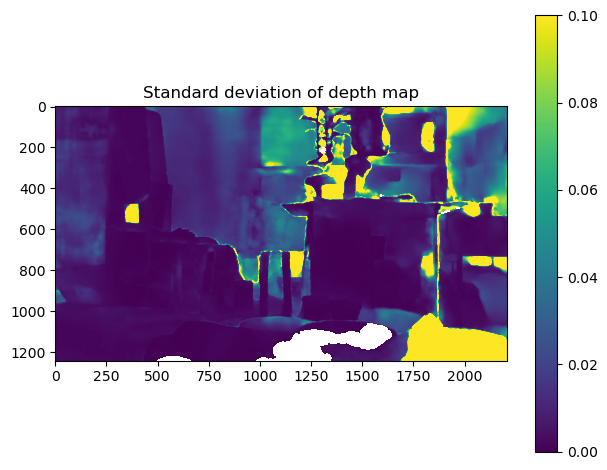

In [56]:
plt.imshow(np.std(avg,axis=2), vmax=0.1)
plt.colorbar()
plt.title('Standard deviation of depth map')
plt.tight_layout()

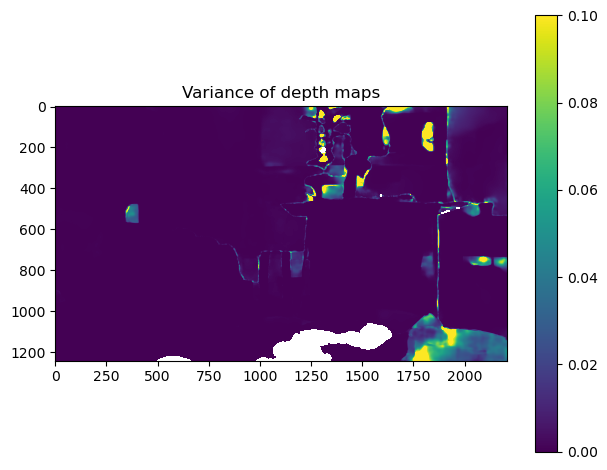

In [57]:
plt.imshow(np.var(avg,axis=2), vmax=0.1)
plt.colorbar()
plt.title('Variance of depth maps')
plt.tight_layout()